In [1]:
## Based on InfantEuks_2_metadataAssociation_2_giantSheet_2_subset_4

In [43]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')

import random
from collections import Counter

## Point

In [53]:
sheetloc = '/data8/Human/FungiPaper/Datasheets/'
fig_loc = '/data8/Human/FungiPaper/figures/'

## Load Euk mapping

In [54]:
RASdb = pd.read_csv(sheetloc + 'MappingListGamma_coverageInfantsParsed_filtered_v1.csv')
RASdb = RASdb[RASdb['name'] != 'Purpureocillium lilacinum']
RASdb['Euk'] = [True if p > 0.1 else False for p in RASdb['pp']]

## Load metadata

In [55]:
Gdb = pd.read_csv(sheetloc + 'SampleMetadata_v3.csv')

In [125]:
Gdb

,sample,CatSampleMetadata$categorical$podA,CatSampleMetadata$categorical$podB,CatSampleMetadata$categorical$podC,CatSampleMetadata$categorical$podChp,CatSampleMetadata$categorical$podD,CatSampleMetadata$categorical$podE,CatSampleMetadata$categorical$podF,CatSampleMetadata$categorical$abAcyclovir,CatSampleMetadata$categorical$abAmoxicillin,CatSampleMetadata$categorical$abAmpicillin,CatSampleMetadata$categorical$abCefazolin,CatSampleMetadata$categorical$abCefepime,CatSampleMetadata$categorical$abCefotaxime,CatSampleMetadata$categorical$abClaforan,CatSampleMetadata$categorical$abClindamycin,CatSampleMetadata$categorical$abFluconazole,CatSampleMetadata$categorical$abGentamycin,CatSampleMetadata$categorical$abNafcillin,CatSampleMetadata$categorical$abNystatin,CatSampleMetadata$categorical$abOfloxacin,CatSampleMetadata$categorical$abVancomycin,CatSampleMetadata$categorical$abZosyn,CatInfSampleMetadata$categorical$feedingBreast,CatInfSampleMetadata$categorical$feedingForumla,CatInfSampleMetadata$categorical$feedingCombination,CatInfSampleMetadata$categorical$firstPodD,CatInfSampleMetadata$categorical$firstPodA,CatInfSampleMetadata$categorical$firstPodC,CatInfSampleMetadata$categorical$firstPodB,CatInfSampleMetadata$categorical$genderF,CatInfSampleMetadata$categorical$birthModeVaginal,SampleMetadata$continuous$DOL,SampleMetadata$continuous$weight,SampleMetadata$continuous$gestationalAge,SampleMetadata$continuous$assemblyCompleteness,SampleMetadata$continuous$seqDepth,SampleMetadata$continuous$daysSinceAb,BacterialNCBITax$continuous$pp_pcov|Actinobacteria,BacterialNCBITax$continuous$pp_pcov|Bacteroidetes,BacterialNCBITax$continuous$pp_pcov|Firmicutes,BacterialNCBITax$continuous$pp_pcov|Fusobacteria,BacterialNCBITax$continuous$pp_pcov|Proteobacteria,BacterialNCBITax$continuous$pp_pcov|Tenericutes,BacterialNCBITax$continuous$pp_pcov|Verrucomicrobia
0,N1_003_011G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,11,822,26.0,0.971504,0.951403,5,0.000000,0.000000,93.687606,0.0,0.000000,0.0,0.0
1,N1_003_013G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,13,822,26.0,0.993186,3.375514,7,0.000000,0.000000,98.287248,0.0,0.000000,0.0,0.0
2,N1_003_015G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,15,822,26.0,0.968978,3.228975,9,1.035104,0.000000,81.502397,0.0,0.000000,0.0,0.0
3,N1_003_017G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,17,822,26.0,0.977795,3.853107,11,22.945043,0.000000,40.904330,0.0,31.024425,0.0,0.0
4,N1_003_018G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,18,822,26.0,0.982860,2.547640,12,4.410257,0.000000,23.332598,0.0,68.755503,0.0,0.0
5,N1_003_019G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,19,822,26.0,0.966666,4.313337,13,8.479903,0.000000,57.052496,0.0,30.585918,0.0,0.0
6,N1_003_021G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,21,822,26.0,0.885864,2.053900,15,1.887167,0.000000,92.570383,0.0,0.000000,0.0,0.0
7,N1_003_022G1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,Fa

## Filter metadata

In [56]:
def filter_giant_sheet(Odb, NECon, NECoff, **kwargs):
    '''
    Filter giant sheet and return filtered sheet
    
    Args:
        Odb: Original giant sheet
        NECon: List of samples associated with NEC
        NECoff: List of samples not associated with NEC
        
    Kwargs:
        Passed to catFilter
    '''
    DBon = Odb[Odb['sample'].isin(NECon)]
    DBoff = Odb[Odb['sample'].isin(NECoff)]
    
    keep = []
    for col in list(Odb.columns):
        if col in ['sample']:
            continue
        typ = col.split('$')[1]
        
        if typ == 'categorical':
            keepCol = _catFilter(DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
            if keepCol:
                keep.append(col)
            else:
                pass
        elif typ == 'continuous':
            keepCol = _conFilter(DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
            if keepCol:
                keep.append(col)
            else:
                pass
    
    Rdb = Odb[['sample'] + keep]
    print("{0:.2f}% of columns filtered out".format(100-(len(Rdb.columns)/len(Odb.columns))*100))
    return Rdb

def _catFilter(onVals, offVals, **kwargs):
    '''
    Return True if keep sample, False if not
    
    Args:
        onVals: list of values of NEC+ samples
        offVals: list of values of NEC- samples
    
    Kwargs:
        minFrac: minimum % of total "True" values
        maxFrac: maximum % of total "True" values
    '''
    minFrac = kwargs.get('minFrac', .1)
    maxFrac = kwargs.get('maxFrac', .9)
    
    True_vals = len([x for x in onVals if x == True] + [x for x in offVals if x == True])
    False_vals = len([x for x in onVals if x == False] + [x for x in offVals if x == False])
    total_vals = True_vals + False_vals
    
    if ((True_vals/total_vals) >= minFrac) & ((True_vals/total_vals) <= maxFrac):
        return True
    else:
        return False
    
def _conFilter(onVals, offVals, **kwargs):
    '''
    Return True if keep sample, False if not
    
    Args:
        onVals: list of values of NEC+ samples
        offVals: list of values of NEC- samples
    
    Kwargs:
        minVal: minimum value to use
        minFrac: minimum % of total values over minVal
        maxNa: maximum % of values that can be NA
    '''
    minVal = kwargs.get('minVal', 0)
    minFrac = kwargs.get('minFrac', .1)
    maxNA = kwargs.get('maxNa', .5)
    
    na_vals = [x for x in (onVals + offVals) if ((x!=x) or (x=='na'))]
    not_na_vals = [float(x) for x in (onVals + offVals) if ((x==x) and (x!='na'))]
    
    Passing_vals = len([x for x in not_na_vals if (x > minVal)])
    total_vals = len(onVals + offVals)
    
    if (len(na_vals)/total_vals) > maxNA:
        return False
    
    if ((Passing_vals/total_vals) >= minFrac):
        return True
    else:
        return False

In [57]:
FGdb = filter_giant_sheet(Gdb, \
               RASdb['sample'][RASdb['Euk'] == True].tolist(),\
               RASdb['sample'][RASdb['Euk'] == False].tolist(),\
               minFrac=.2, maxFrac=.8, maxNa=0.2)

# Remove everything except phyla-level
FFGdb = FGdb[[c for c in FGdb.columns if (c.split('$')[0] != 'BacterialNCBITax')\
              or len(c.split('$')[2].split('|')) == 2]]
FFGdb = FFGdb[[c for c in FFGdb.columns if (c.split('$')[0] != 'BacterialNCBIGrowth')\
              or len(c.split('$')[2].split('|')) == 2]]
print(len(FFGdb.columns)/len(FGdb.columns))

68.89% of columns filtered out
1.0


# Run stats

In [58]:
def giantSheetStats(Odb, NECon, NECoff, **kwargs):
    '''
    Run stat tests on the giant sheet
    
    Args:
        Odb: Original giant sheet
        NECon: List of samples associated with NEC
        NECoff: List of samples not associated with NEC
    '''
    table = defaultdict(list)
    
    DBon = Odb[Odb['sample'].isin(NECon)]
    DBoff = Odb[Odb['sample'].isin(NECoff)]
    for col in list(Odb.columns):
        if col in ['sample']:
            continue
            
        typ = col.split('$')[1]
        p = _run_stats(typ, DBon[col].tolist(), DBoff[col].tolist(), **kwargs)
        if p == p:
            table['explVar'].append(col)
            table['p'].append(p)
            table['type'].append(typ)
            table['name'].append(col.split('$')[0])
    
    STdb = pd.DataFrame(table)
    STdb['q'] = p_adjust_bh(STdb['p'])
    #STdb = _sophisticated_pvalue_correction(STdb)
    return STdb

def _run_stats(typ, onVals, offVals, **kwargs):
    '''
    Run the appropriate statistical test and return a p-value
    '''
    if typ == 'categorical':
        r1 = [len([x for x in onVals if x==True]),\
              len([x for x in onVals if x==False])]
        r2 = [len([x for x in offVals if x==True]),\
              len([x for x in offVals if x==False])]
        oddsratio, pvalue = scipy.stats.fisher_exact([r1, r2])
        return pvalue
    
    elif typ == 'continuous':
        n = [x for x in onVals if ((x==x) & (x!='na'))]
        o = [x for x in offVals if ((x==x) & (x!='na'))]
        stat, p = scipy.stats.ranksums(n, o)
        return p
    
def _sophisticated_pvalue_correction(STdb):
    '''
    Correct within category and between category 
    '''
    x2q = {}
    bests = []
    for name, db in STdb.groupby('name'):
        db['q'] = p_adjust_bh(list(db['p']))
        x2q = {**x2q, **db.set_index('explVar')['q'].to_dict()}
        
        best = db.sort_values('p')['explVar'].tolist()[0]
        bests.append(best)
        
    STdb['q'] = STdb['explVar'].map(x2q)
    
    bdb = STdb[[True if x in bests else False for x in STdb['explVar']]]
    bdb['qq'] = p_adjust_bh(list(bdb['q']))
    b2q = bdb.set_index('explVar')['qq'].to_dict()
    
    STdb['qq'] = STdb['explVar'].map(b2q)
    return STdb

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(float(len(p)), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [59]:
FSdb = giantSheetStats(FFGdb,\
               RASdb['sample'][RASdb['Euk'] == True].tolist(),\
               RASdb['sample'][RASdb['Euk'] == False].tolist())
#FSdb.sort_values('q').head(10)
FSdb[~FSdb['q'].isna()].sort_values('q')

,explVar,name,p,type,q
9,SampleMetadata$continuous$daysSinceAb,SampleMetadata,0.000006,continuous,0.000072
4,SampleMetadata$continuous$DOL,SampleMetadata,0.000066,continuous,0.000426
8,SampleMetadata$continuous$seqDepth,SampleMetadata,0.132593,continuous,0.351691
11,BacterialNCBITax$continuous$pp_pcov|Firmicutes,BacterialNCBITax,0.135266,continuous,0.351691
12,BacterialNCBITax$continuous$pp_pcov|Proteobact...,BacterialNCBITax,0.127369,continuous,0.351691
1,CatInfSampleMetadata$categorical$firstPodC,CatInfSampleMetadata,0.171703,categorical,0.372023
5,SampleMetadata$continuous$weight,SampleMetadata,0.236166,continuous,0.438595
0,CatSampleMetadata$categorical$podC,CatSampleMetadata,0.410004,categorical,0.604505
2,CatInfSampleMetadata$categorical$genderF,CatInfSampleMetadata,0.418504,categorical,0.604505
10,BacterialNCBITax$continuous$pp_pcov|Actinobact...,BacterialNCBITax,0.516359,continuous,0.671267


In [152]:
FSdb.to_csv(sheetloc + 'SampleMetadata_Stats_v2.csv', index=False)

In [61]:
STdb = FSdb[FSdb['q'] <= .05]
ISTdb = STdb
STdb.sort_values('q')

,explVar,name,p,type,q
9,SampleMetadata$continuous$daysSinceAb,SampleMetadata,0.000006,continuous,0.000072
4,SampleMetadata$continuous$DOL,SampleMetadata,0.000066,continuous,0.000426


In [150]:
FSdb

,explVar,name,p,type,q
0,CatSampleMetadata$categorical$podC,CatSampleMetadata,0.410004,categorical,0.604505
1,CatInfSampleMetadata$categorical$firstPodC,CatInfSampleMetadata,0.171703,categorical,0.372023
2,CatInfSampleMetadata$categorical$genderF,CatInfSampleMetadata,0.418504,categorical,0.604505
3,CatInfSampleMetadata$categorical$birthModeVaginal,CatInfSampleMetadata,0.777692,categorical,0.777692
4,SampleMetadata$continuous$DOL,SampleMetadata,0.000066,continuous,0.000426
5,SampleMetadata$continuous$weight,SampleMetadata,0.236166,continuous,0.438595
6,SampleMetadata$continuous$gestationalAge,SampleMetadata,0.749474,continuous,0.777692
7,SampleMetadata$continuous$assemblyCompleteness,SampleMetadata,0.571014,continuous,0.674835
8,SampleMetadata$continuous$seqDepth,SampleMetadata,0.132593,continuous,0.351691
9,SampleMetadata$continuous$daysSinceAb,SampleMetadata,0.000006,continuous,0.000072


# Figure v1

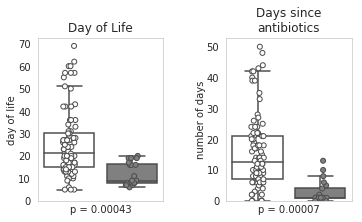

In [62]:
Fdb = Gdb.copy()
Fdb = pd.merge(Gdb, RASdb, on='sample')
Fdb = Fdb[STdb['explVar'].tolist() + ['Euk']]

n2n = {'DOL':'Day of Life',\
      'daysSinceAb':'Days since\nantibiotics',\
      'pp_pcov|Proteobacteria':'Proteobacteria\nrelative abundance'}
n2l = {'DOL':'day of life',\
      'daysSinceAb':'number of days',\
      'pp_pcov|Proteobacteria':'relative abundance (%)'}

db = Fdb
label = 'Euk'
to_show = Fdb.columns
db.sort_values('Euk', inplace=True, ascending=False)

for i, pl in enumerate(to_show):
    if pl == 'Euk':
        continue
        
    plt.subplot(1, len(to_show), i+1)
    fdb = db[~db[label].isna()]
    fdb = fdb[fdb[pl] < 1000]
    
    sns.boxplot(data=fdb, y=pl, x=label, showfliers=False, palette=['white', 'grey'])
    sns.stripplot(data=fdb, x=label, y=pl, \
          jitter=True, linewidth=1, size=5, edgecolor='gray', palette=['white', 'grey'])

    plt.gca().yaxis.grid(False)
    plt.xlabel('p = {0:.5f}'.format(ISTdb['q'][ISTdb['explVar'] == pl].tolist()[0]))
    plt.xticks([])
    plt.ylim(0,)
    plt.title(n2n[pl.split('$')[2]])
    plt.ylabel(n2l[pl.split('$')[2]])
    plt.gca().yaxis.labelpad=1

plt.subplots_adjust(wspace=0.5)
plt.gcf().set_size_inches(3*(len(to_show)), 3)
#plt.suptitle('statistical associations')

#plt.savefig(fig_loc + 'FigureC_C.pdf', bbox_inches='tight')
plt.show()

## Figure V2

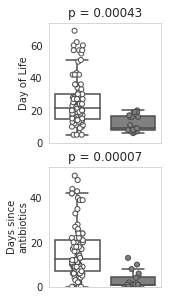

In [64]:
Fdb = Gdb.copy()
Fdb = pd.merge(Gdb, RASdb, on='sample')
Fdb = Fdb[ISTdb['explVar'].tolist() + ['Euk']]
# Fdb = pd.melt(Fdb, id_vars=['Euk'])
# Fdb = Fdb[Fdb['value'] < 1000]

n2n = {'DOL':'Day of Life',\
      'daysSinceAb':'Days since\nantibiotics',\
      'pp_pcov|Proteobacteria':'Proteobacteria\nrelative abundance (%)'}
n2l = {'DOL':'day of life',\
      'daysSinceAb':'number of days',\
      'pp_pcov|Proteobacteria':'relative abundance (%)'}

db = Fdb
label = 'Euk'
to_show = Fdb.columns
db.sort_values('Euk', inplace=True, ascending=False)

for i, pl in enumerate(to_show):
    if pl == 'Euk':
        continue
        
    plt.subplot(len(to_show), 1, i+1)
    fdb = db[~db[label].isna()]
    fdb = fdb[fdb[pl] < 1000]
    
    sns.boxplot(data=fdb, y=pl, x=label, showfliers=False, palette=['white', 'grey'])
    sns.stripplot(data=fdb, x=label, y=pl, \
          jitter=True, linewidth=1, size=5, edgecolor='gray', palette=['white', 'grey'])

    plt.gca().yaxis.grid(False)
    #plt.xlabel('p = {0:.3f}'.format(ISTdb['q'][ISTdb['explVar'] == pl].tolist()[0]))
    plt.xlabel('')
    plt.title('p = {0:.5f}'.format(ISTdb['q'][ISTdb['explVar'] == pl].tolist()[0]))
    plt.xticks([])
    plt.ylim(0,)
    #plt.title(n2n[pl.split('$')[2]])
    #plt.ylabel(n2l[pl.split('$')[2]])
    plt.ylabel(n2n[pl.split('$')[2]])
    plt.gca().yaxis.labelpad=1

plt.subplots_adjust(wspace=0.5)
plt.gcf().set_size_inches(2, 2.5*(len(to_show)))
#plt.suptitle('statistical associations')

#plt.savefig(fig_loc + 'FigureC_C.4.pdf', bbox_inches='tight')
plt.show()

# Test if having one euk pre-disposes you to having another

### Check out what you have

In [83]:
Odb = pd.read_csv(sheetloc + 'MappingListGamma_coverageInfantsParsed.csv')
len(Odb['infant'].unique())

161

In [84]:
Tdb = RASdb.drop_duplicates(subset=['infant', 'name'])
Tdb['infant'].value_counts()

N5_275    3
N2_070    2
N5_254    1
SP_CRL    1
N1_023    1
N3_182    1
S2_002    1
S2_006    1
N5_264    1
N2_064    1
Name: infant, dtype: int64

In [85]:
sum(list(dict(Tdb['infant'].value_counts()).values()))

13

In [86]:
len(Tdb['infant'].value_counts())

10

### Run permutations

In [109]:
def run_permutations(n=161, c=13, p=10, fpi=False):
    '''
    Run premutations and return dataframe with results
    
    n = number of infants
    c = number of fungi to choose
    p = number of permutations to run
    '''
    table = defaultdict(list)
    
    for iteration in range(0, p):
        # pick the numbers
        chosen = [random.randrange(1,n) for x in range(c)]
        counts = sorted(list(dict(Counter(chosen)).values()))
        
        # do the tests
        twoOvertwo = counts[-2] >= 2
        topTwoOverFive = sum(counts[-2:]) >= 5
        tenUnique = len(set(chosen)) <= 10
        inc_fpi = (len(chosen) / len(set(chosen))) >= fpi
        
        table['iteration'].append(iteration)
        table['twoOvertwo'].append(twoOvertwo)
        table['topTwoOverFive'].append(topTwoOverFive)
        table['tenUnique'].append(tenUnique)
        table['number_individuals'].append(len(set(chosen)))
        table['fungi_per_infant_stat'].append(inc_fpi)
        table['fungi_per_infant'].append(len(chosen) / len(set(chosen)))
    
    return pd.DataFrame(table)

random.seed(7)
Pdb = run_permutations(n=161, c=13, p=10000, fpi=(13/10))
#Pdb = run_permutations(n=161, c=13, p=1)

### Test for significance

In [110]:
vars_tested = list(set(Pdb.columns) - set(['iteration','number_individuals', 'fungi_per_infant']))
for var in vars_tested:
    counts = dict(Pdb[var].value_counts())
    t = counts[True]
    tot = counts[True] + counts[False]
    print("{0:15} - {1:3} of {2:,} are True ({3:.3f}%), p={4:.3f}".format(var, \
                t, tot, (t / tot)*100, (t / tot)*(1)))#len(vars_tested))))

fungi_per_infant_stat -  79 of 10,000 are True (0.790%), p=0.008
tenUnique       -  79 of 10,000 are True (0.790%), p=0.008
twoOvertwo      - 680 of 10,000 are True (6.800%), p=0.068
topTwoOverFive  -  28 of 10,000 are True (0.280%), p=0.003


## Plot

/home/mattolm/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


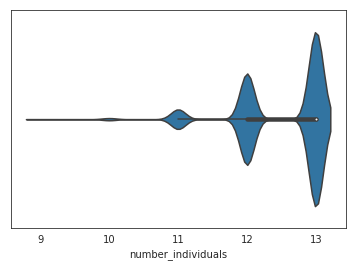

In [93]:
sns.violinplot(Pdb['number_individuals'], showfliers=False)

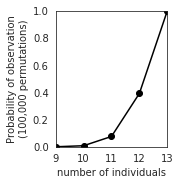

In [94]:
indA = []
probs = []
for inds in Pdb['number_individuals'].unique():
    t = len([x for x in Pdb['number_individuals'] if x <= inds])
    tot = len(Pdb['number_individuals'])
    p = (t / tot)
    #print("{0} - {1:.3f}".format(inds, p))
    indA.append(inds)
    probs.append(p)
    
sns.set_style('white')
plt.plot(indA, probs, '-o', c='black')

plt.xticks(range(9,14))
plt.ylim(0,1)
plt.xlim(9,13)
plt.xlabel('number of individuals')
plt.ylabel('Probability of observation\n(100,000 permutations)')

plt.gcf().set_size_inches(2, 2.5)
#plt.savefig(fig_loc + 'FigureC_D.4.pdf', bbox_inches='tight')
plt.show()

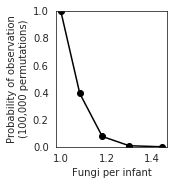

In [149]:
indA = []
probs = []
for inds in Pdb['fungi_per_infant'].unique():
    t = len([x for x in Pdb['fungi_per_infant'] if x >= inds])
    tot = len(Pdb['fungi_per_infant'])
    p = (t / tot)
    #print("{0} - {1:.3f}".format(inds, p))
    indA.append(inds)
    probs.append(p)
    
sns.set_style('white')
plt.plot(indA, probs, '-o', c='black')


#plt.xticks([float("{0:.2f}".format(x)) for x in Pdb['fungi_per_infant'].unique()])
plt.ylim(0,1)
#plt.xlim(9,13)
plt.xlabel('Fungi per infant')
plt.ylabel('Probability of observation\n(100,000 permutations)')

plt.gcf().set_size_inches(2, 2.5)
#plt.savefig(fig_loc + 'FigureC_D.5.pdf', bbox_inches='tight')
plt.show()

## Test association between DOL and antibiotic adminitration

In [145]:
def compare_distributions(one, two, lone, ltwo, plot=True):
    stat, p = scipy.stats.ranksums(one, two)
    
    # Plot
    if plot:
        x = ([lone]*len(one)) + ([ltwo]*len(two))
        sns.boxplot(x=x, y=(one + two))
        sns.stripplot(x=x, y=(one + two), \
                          jitter=True, linewidth = 1, size = 5)
        plt.gca().set_title("p = {0:.3E}".format(p))
    else:
        return p

In [146]:
## Load AB info
Ndb = pd.read_csv(sheetloc + 'parsed_AB_info_v1.csv')

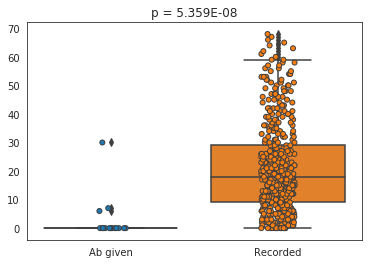

In [148]:
## Get a distribution of days recorded
Rdb = Gdb.copy()
Rdb['infant'] = [x[:6] for x in Rdb['sample']]
Rdb['DOL'] = [int(x[7:10]) for x in Rdb['sample']]
Rdb = Rdb[Rdb['infant'].isin(Ndb['infant'])]
Rdb = Rdb[['infant', 'DOL']]

table = defaultdict(list)
for i, db in Rdb.groupby('infant'):
    m = db['DOL'].max()
    for d in range(0,m):
        table['metric'].append('recorded')
        table['day'].append(d)
        table['infant'].append(i)

## Add a distribution of Abs given
for i, row in Ndb.iterrows():
    table['metric'].append('ab_given')
    table['day'].append(row['start'])
    table['infant'].append(row['infant'])

## Plot
Rdb = pd.DataFrame(table)
ab = Rdb[(Rdb['metric'] == 'ab_given')]['day'].tolist()
rec = Rdb[(Rdb['metric'] == 'recorded')]['day'].tolist()
compare_distributions(ab, rec, 'Ab given', 'Recorded')